# Data Preparation

In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import EMNIST

data_dir = "data"

# Load the EMNIST dataset
train_dataset = EMNIST(
    root=data_dir,
    train=True,
    split="balanced",
    download=True,  # Downloads dataset if not already downloaded
    transform=transforms.ToTensor(),  # Converts PIL images to Torch tensors
)

test_dataset = EMNIST(
    root=data_dir,
    train=False,
    split="balanced",
    download=True,
    transform=transforms.ToTensor(),
)

# Display dataset details
print(f"Training set size: {len(train_dataset)} images")
print(f"Test set size: {len(test_dataset)} images")

Training set size: 112800 images
Test set size: 18800 images


# Exploring Dataset

In [2]:
classes = train_dataset.classes
print(f"Classes in the dataset:\n{classes}")

Classes in the dataset:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


Image shape: torch.Size([1, 28, 28])


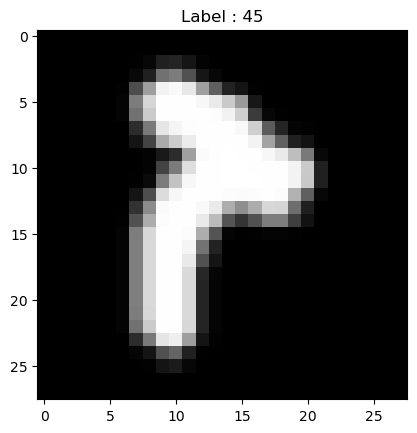

Image shape: torch.Size([1, 28, 28]) (channels, height, width)


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

image, label = train_dataset[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(), cmap="gray") # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(f"Label : {label}")
plt.show()
print(f"Image shape: {image.shape} (channels, height, width)")

In [4]:
image

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039,
          0.0275, 0.1255, 0.1412, 0.0824, 0.0118, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0314,
          0.1294, 0.4431, 0.4863, 0.3176, 0.0863, 0.0275, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

# Calculate Mean and Standard Deviation

In [5]:
import torch
import torchvision
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_dataset, batch_size=1024, shuffle=False)

def get_mean_std(loader):
    # VAR[X] = E[X**2] - E[X]**2
    channels_sum, channels_squares_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squares_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squares_sum/num_batches - mean**2)**0.5

    return mean, std

mean, std = get_mean_std(train_loader)
print(f"Mean: {mean}")
print(f"Mean: {std}")

Mean: tensor([0.1751])
Mean: tensor([0.3332])


# Loading Data

In [6]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

data_transform = {
    'train' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([mean,], [std,])
    ]),

    'test' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([mean,], [std,])
    ]),
}

# Reloading dataset

dataset = {
    'train': datasets.EMNIST(
        root = data_dir,
        split = 'balanced',
        train = True,
        download = True,
        transform = data_transform['train']
    ),

    'test': datasets.EMNIST(
        root = data_dir,
        split = 'balanced',
        train = False,
        download = True,
        transform = data_transform['test']
    )
}

dataloaders = {
    x: DataLoader(dataset[x], batch_size=128, shuffle=True, num_workers=2)
    for x in ['train', 'test']
}

class_names = dataset['train'].classes
dataset_sizes = {x: len(dataset[x]) for x in ['train', 'test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize Data

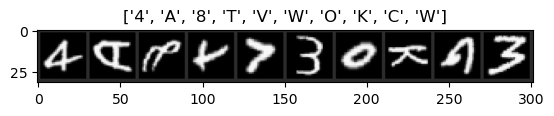

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.1736,])
    std = np.array([0.3248,])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:10], nrow=10)

imshow(out, title=[class_names[x] for x in classes[:10]])

# Training model

In [8]:
import torch
from tempfile import TemporaryDirectory
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import time
import os

torch.cuda.empty_cache()
cudnn.benchmark = True

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

# Visualizing model predictions

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Finetuning ConvNet

In [10]:
import torch
import torchvision
from torchvision.models import resnet50

model = resnet50(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
num_classes = len(class_names)
model.fc = nn.Linear(num_ftrs, num_classes)
model.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train and evaluate

In [11]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


/home/moritz/miniconda3/envs/mnist_ml/lib/python3.12/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:310.)
  return F.linear(input, self.weight, self.bias)


train Loss: 0.6114 Acc: 0.8146
test Loss: 0.3234 Acc: 0.8837

Epoch 1/9
----------
train Loss: 0.2783 Acc: 0.8963
test Loss: 0.3089 Acc: 0.8880

Epoch 2/9
----------
train Loss: 0.2282 Acc: 0.9119
test Loss: 0.3024 Acc: 0.8931

Epoch 3/9
----------
train Loss: 0.1947 Acc: 0.9220
test Loss: 0.3156 Acc: 0.8912

Epoch 4/9
----------
train Loss: 0.1682 Acc: 0.9318
test Loss: 0.3270 Acc: 0.8849

Epoch 5/9
----------
train Loss: 0.1463 Acc: 0.9398
test Loss: 0.3448 Acc: 0.8886

Epoch 6/9
----------
train Loss: 0.1301 Acc: 0.9459
test Loss: 0.3740 Acc: 0.8887

Epoch 7/9
----------
train Loss: 0.0902 Acc: 0.9652
test Loss: 0.3589 Acc: 0.8952

Epoch 8/9
----------
train Loss: 0.0755 Acc: 0.9713
test Loss: 0.3690 Acc: 0.8948

Epoch 9/9
----------
train Loss: 0.0669 Acc: 0.9751
test Loss: 0.3811 Acc: 0.8936

Training complete in 9m 1s
Best val Acc: 0.895160


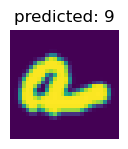

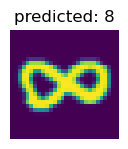

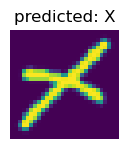

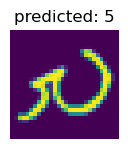

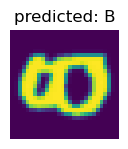

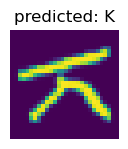

In [12]:
visualize_model(model)

# Visualize model prediction with actual values

In [13]:
def visualize_model_predictions(model, dataloader, class_names, device, num_images):

    was_training = model.training
    model.eval()
    images_shown = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                images_shown += 1
                ax = plt.subplot(num_images // 2, 2, images_shown)
                ax.axis('off')
                ax.set_title(f'Actual: {class_names[labels[j]]}\nPredicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_shown == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

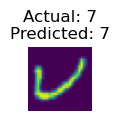

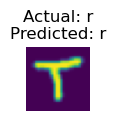

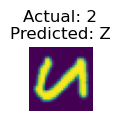

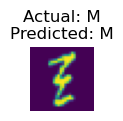

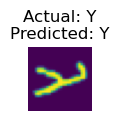

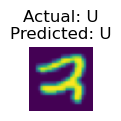

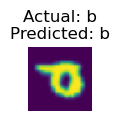

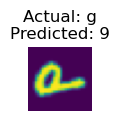

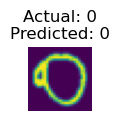

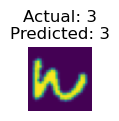

In [14]:
visualize_model_predictions(
    model=model,
    dataloader=dataloaders['test'],
    class_names=class_names,
    device=device,
    num_images=10
)